# Solar Position Algorithms

> This Notebook is largely based on the [Solar Position](https://assessingsolar.org/notebooks/solar_position.html) article by _The Assessing Solar Community (2022)_.


Following we demonstrate the calculation of solar position angles used to calculate the photovoltaic power output in PVGIS.

## Programmatic preamble

In [1]:
from zoneinfo import ZoneInfo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pvgisprototype.api.position.overview import model_solar_position_overview_series
from pvgisprototype import Longitude
from pvgisprototype import Latitude
from pvgisprototype import SurfaceOrientation
from pvgisprototype import SurfaceTilt
from pvgisprototype.constants import DEGREES
from pvgisprototype.api.position.models import SolarPositionModel
from pvgisprototype.api.position.models import SolarIncidenceModel

## Data preparation

First, we define some basic parameters for a location, in which case it is a solar panel located behind the ESTI Lab, in the JRC, European Commission.

In [2]:
latitude = Latitude(value=45.812, unit=DEGREES)
longitude = Longitude(value=8.628, unit=DEGREES)
timezone = ZoneInfo("UTC")
start_time = '2010-01-01 00:10:00'
end_time = '2010-12-31 23:59:00'
frequency = 'h'
timestamps = pd.date_range(start_time, end_time, freq=frequency, tz=timezone)
surface_orientation = SurfaceOrientation(value=180, unit=DEGREES)
surface_tilt = SurfaceTilt(value=45, unit=DEGREES)

One important note : we set the start time at +10' fom the beginning of the first hour of the first day! This is to match the timestamps generated by PVGIS v5.2 that acount for the real time of acquisitin of SARAH3 data and obviously for the specific location.

In [3]:
from pandas import read_csv
pvgis_52_orientation_180_tilt_45_2010 = read_csv('t.csv')

## Solar position parameters

We then use the `model_solar_position_overview_series()` function to calculate a series of solar position parameters.

In [4]:
(
    declination,
    hour_angle,
    zenith,
    altitude,
    azimuth,
    orientation,
    tilt,
    incidence
) = model_solar_position_overview_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angles=False,
)

And as simple as that we can get an overview of the positing parameters for the specific period over the locaton of our interest.

## Visualisation

We can generate a Pandas `DataFrame` for easy visualization

In [5]:
data = pd.DataFrame({
    'Datetime': timestamps, 
    'Solar Declination': declination.degrees,
    'Solar Hour Angle': hour_angle.degrees,
    'Solar Zenith': zenith.degrees,
    'Solar Altitude': altitude.degrees,
    'Solar Azimuth': azimuth.degrees,
    'Solar Incidence': surface_orientation.degrees,
    'Solar Incidence': incidence.degrees,
})
data.set_index('Datetime', inplace=True)

### Solar zenith and azimuth

We calculate the solar zenith and azimuth angles for 21 June 2010.

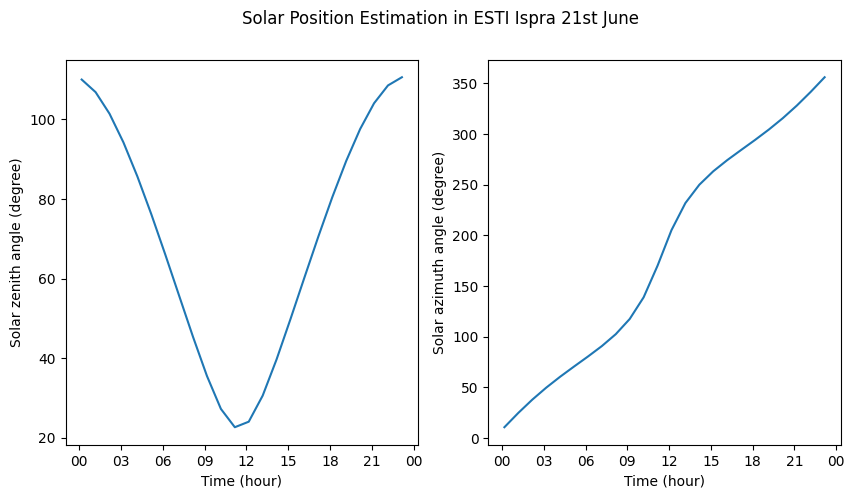

In [6]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Solar Position Estimation in ESTI Ispra 21st June')

# plot for solar zenith angle
ax1.plot(data.loc['2010-06-21']['Solar Zenith'])
ax1.set_ylabel('Solar zenith angle (degree)')
ax1.set_xlabel('Time (hour)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth angle
ax2.plot(data.loc['2010-06-21']['Solar Azimuth'])
ax2.set_ylabel('Solar azimuth angle (degree)')
ax2.set_xlabel('Time (hour)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

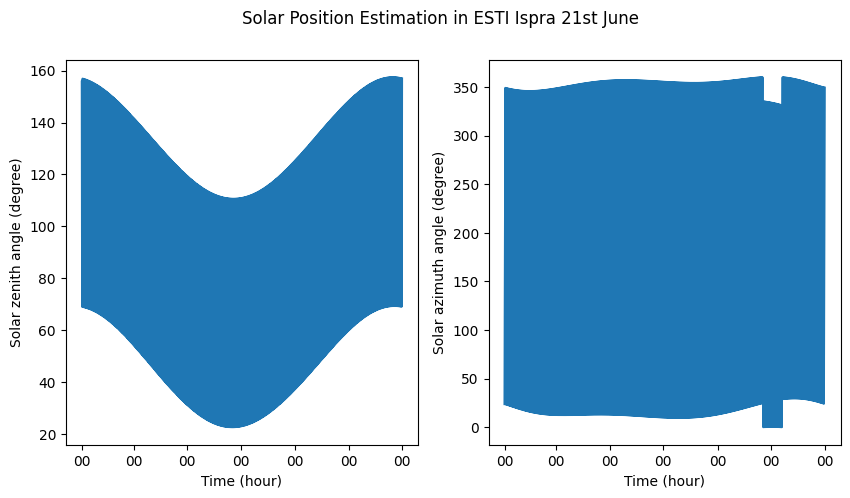

In [7]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Solar Position Estimation in ESTI Ispra 21st June')

# plot for solar zenith angle
ax1.plot(data.loc['2010']['Solar Zenith'])
ax1.set_ylabel('Solar zenith angle (degree)')
ax1.set_xlabel('Time (hour)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth angle
ax2.plot(data.loc['2010']['Solar Azimuth'])
ax2.set_ylabel('Solar azimuth angle (degree)')
ax2.set_xlabel('Time (hour)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

One more thing before engaging in to comparisons : we need to transform the timestamps of the PVGIS v5.2 data frame to be a Pandas DatetimeIndex, as the timestamps we use for the rest of the data.

In [10]:
# pvgis_52.index =
from pandas import to_datetime
pvgis_52_orientation_180_tilt_45_2010.index = to_datetime(pvgis_52_orientation_180_tilt_45_2010['Timestamp'])
pvgis_52 = pvgis_52_orientation_180_tilt_45_2010.tz_localize(timezone)

# pvgis_52.index = pvgis_52.index - pd.Timedelta(minutes=10)
# pvgis_52


## Comparison of algorithms

Bellow we calculate the differences in solar **zenith** and **azimuth** between PVGIS' implementation of NOAA solar geometry equations against NREL's SPA, PyEphem and Ephemeris, all implemented in `pvlib`.

In [11]:
# Prepare pvlib data
import pvlib
from pvlib.location import Location
site = Location(45.812, 8.628, 'UTC', 200, 'ESTI Ispra') # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
# times = pd.date_range(start_time, end_time, freq=frequency, tz=site.tz)
solpos_nrel = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='nrel_numpy')
solpos_pyephem = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='pyephem')
solpos_ephemeris = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='ephemeris')

We can visualize the differences in the estimations of the **solar zenith angle**:

## Solar zenith

### PVGIS v6 vs others

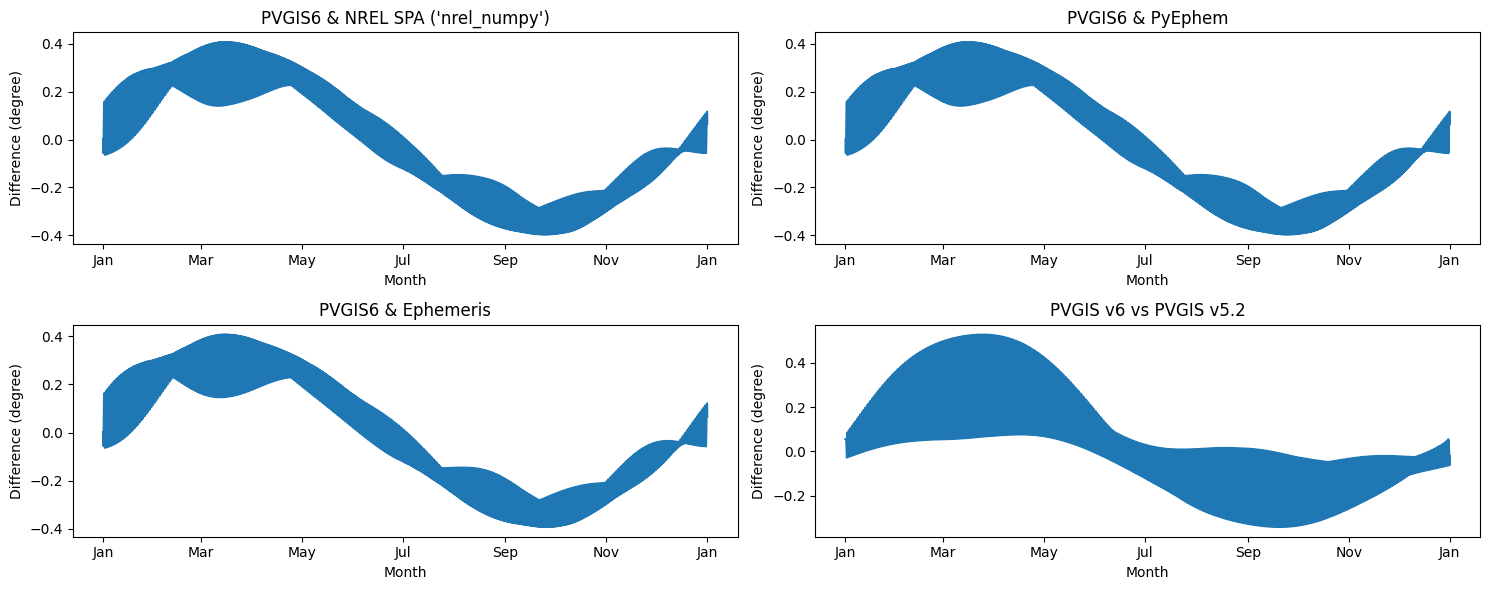

In [22]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].plot(data['Solar Zenith']-solpos_nrel['zenith'])
axs[1].plot(data['Solar Zenith']-solpos_pyephem['zenith'])
axs[2].plot(data['Solar Zenith']-solpos_ephemeris['zenith'])
axs[3].plot(data['Solar Zenith']-(90 - pvgis_52['Solar Altitude']))

# Add characteristics to each subplot in a loop
plots = ["PVGIS6 & NREL SPA ('nrel_numpy')", "PVGIS6 & PyEphem", "PVGIS6 & Ephemeris", "PVGIS v6 vs PVGIS v5.2"]
for i in range(4):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degree)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

## NREL SPA vs others

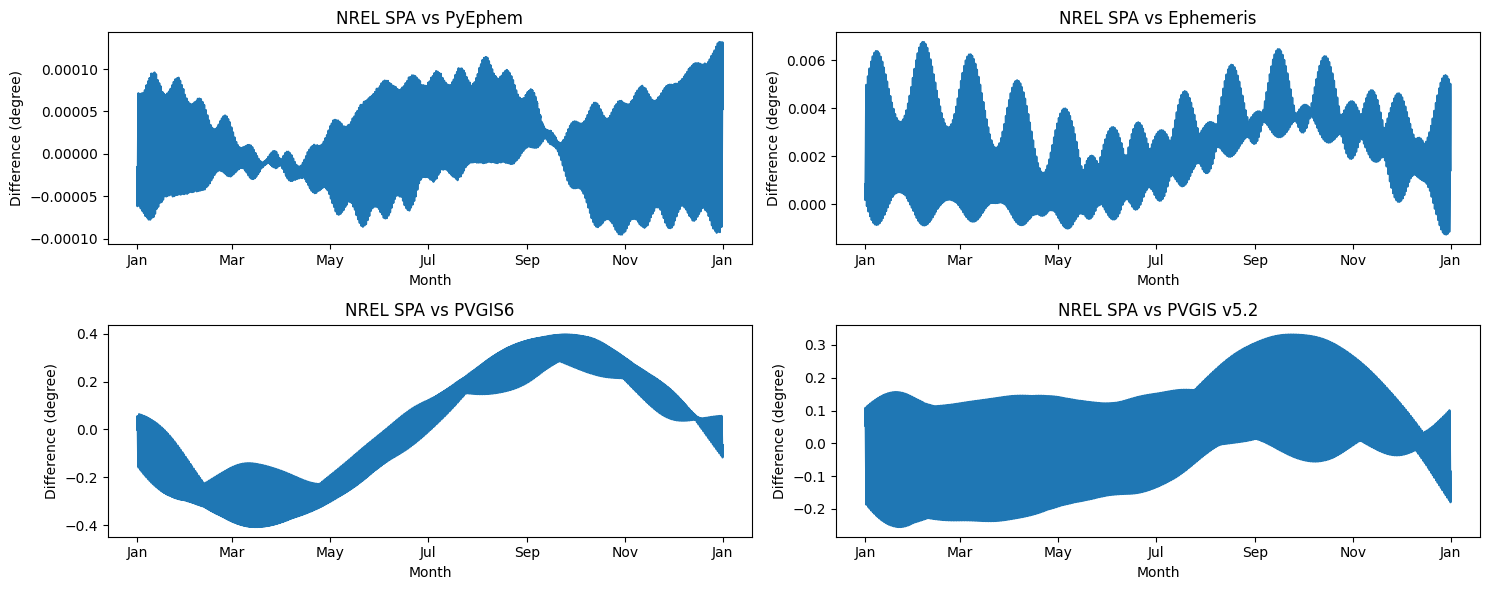

In [23]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].plot(solpos_nrel['zenith'] - solpos_pyephem['zenith'])
axs[1].plot(solpos_nrel['zenith'] - solpos_ephemeris['zenith'])
axs[2].plot(solpos_nrel['zenith'] - data['Solar Zenith'])
axs[3].plot(solpos_nrel['zenith'] - (90 - pvgis_52['Solar Altitude']))

# Add characteristics to each subplot in a loop
plots = ["NREL SPA vs PyEphem", "NREL SPA vs Ephemeris", "NREL SPA vs PVGIS6", "NREL SPA vs PVGIS v5.2"]
for i in range(4):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degree)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

## Solar azimuth

Then we can visualize the differences in the estimations of the **solar azimuth angle** as well:

In [24]:
# #print(data['Solar Azimuth'][:9])

# print(solpos_nrel['azimuth'][5950:6000])

# print(pvgis_52['Solar Azimuth'][5950:6000])


# (data['Solar Azimuth'][5900:6000] - pvgis_52['Solar Azimuth'][5900:6000]).plot()

### PVGIS v6 vs others

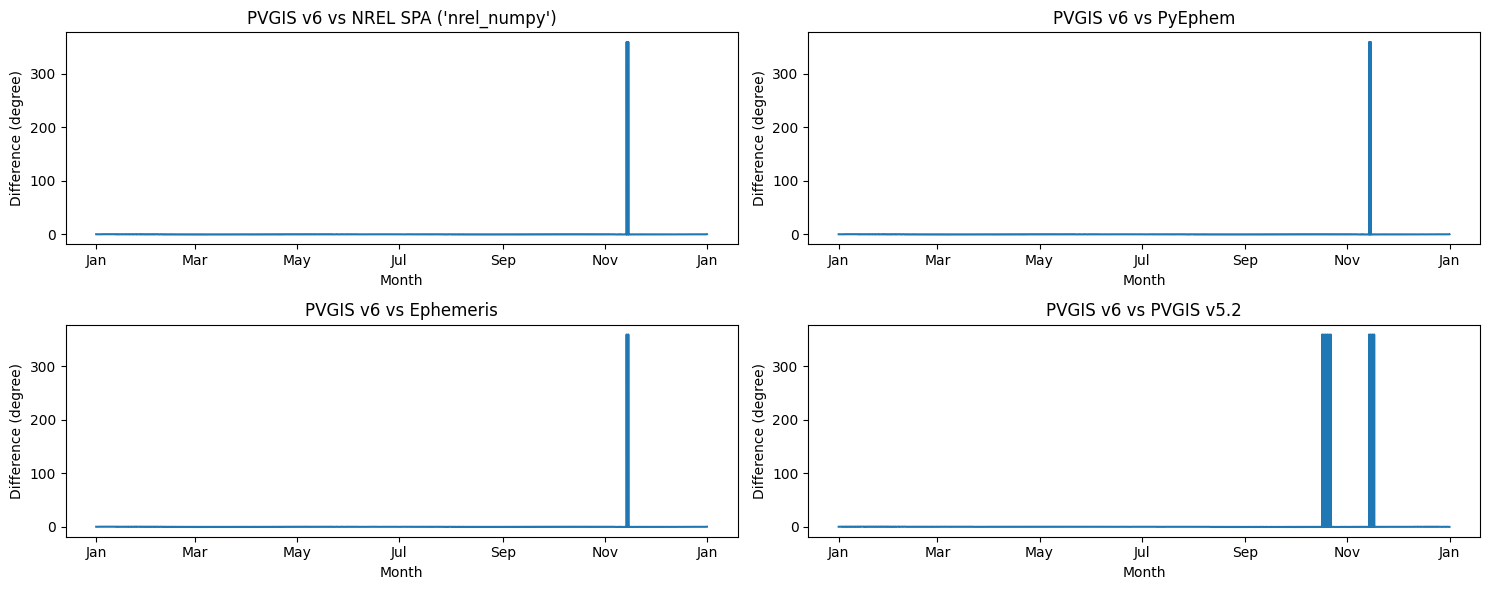

In [25]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

axs[0].plot(data['Solar Azimuth']-solpos_nrel['azimuth'])
axs[1].plot(data['Solar Azimuth']-solpos_pyephem['azimuth'])
axs[2].plot(data['Solar Azimuth']-solpos_ephemeris['azimuth'])
axs[3].plot(data['Solar Azimuth']-pvgis_52['Solar Azimuth'])

# Add characteristics to each subplot in a loop
plot_titles = ["PVGIS v6 vs NREL SPA ('nrel_numpy')", "PVGIS v6 vs PyEphem", "PVGIS v6 vs Ephemeris", "PVGIS v6 vs PVGIS v5.2"]
for idx in range(4):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degree)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

What is this huge difference ?

<Axes: >

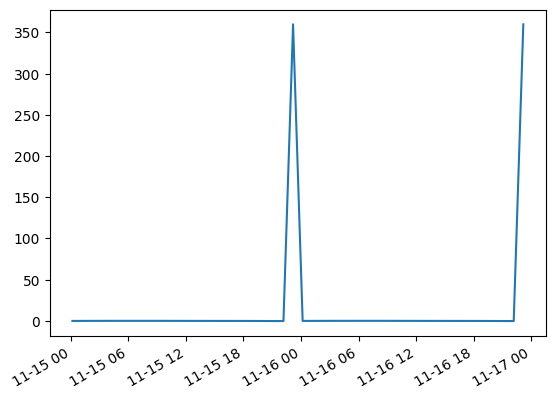

In [17]:
(solpos_nrel['2010-11-15':'2010-11-16']['azimuth'] - pvgis_52['2010-11-15':'2010-11-16']['Solar Azimuth']).plot()

### NREL SPA v6 vs others

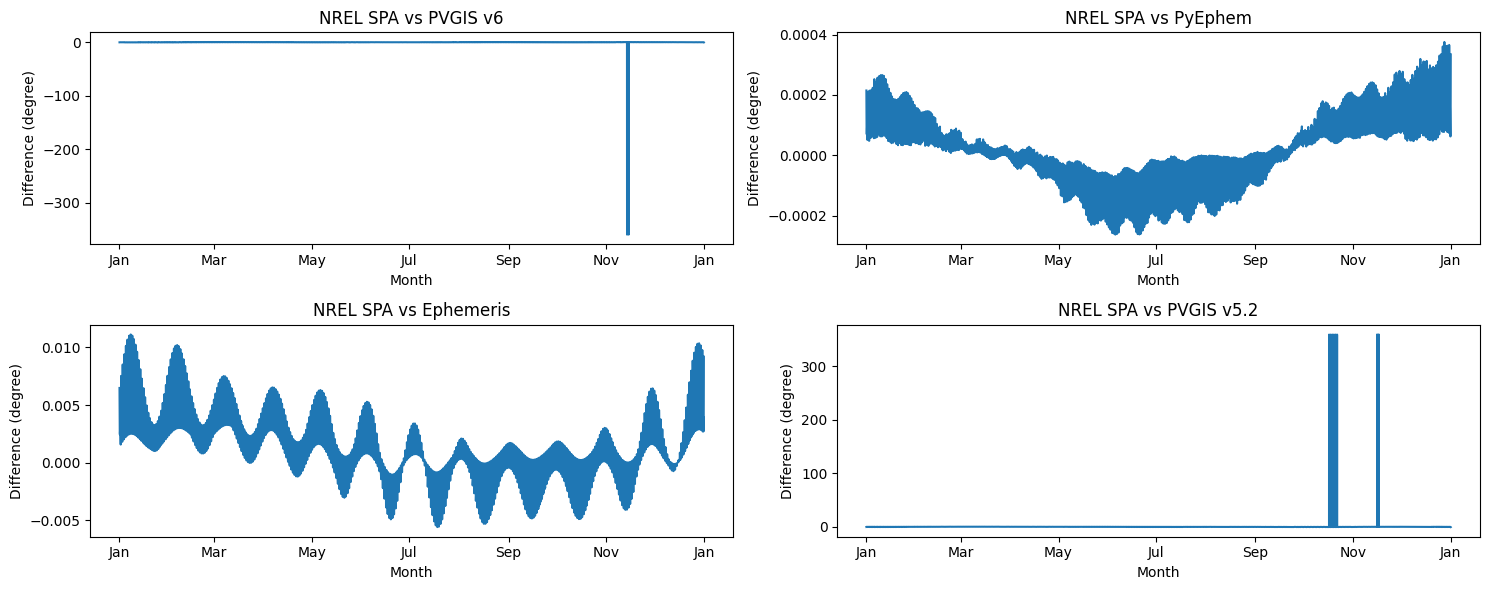

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

axs[0].plot(solpos_nrel['azimuth'] - data['Solar Azimuth'])
axs[1].plot(solpos_nrel['azimuth'] - solpos_pyephem['azimuth'])
axs[2].plot(solpos_nrel['azimuth'] - solpos_ephemeris['azimuth'])
axs[3].plot(solpos_nrel['azimuth'] - pvgis_52['Solar Azimuth'])
# axs[3].plot(solpos_nrel['2010-11-01':]['azimuth'] - pvgis_52['2010-11-01':]['Solar Azimuth'])
# Add characteristics to each subplot in a loop
plot_titles = ["NREL SPA vs PVGIS v6", "NREL SPA vs PyEphem", "NREL SPA vs Ephemeris", "NREL SPA vs PVGIS v5.2"]
for idx in range(4):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degree)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

<Axes: >

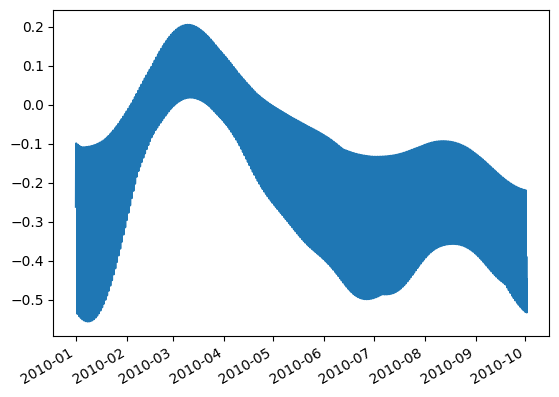

In [31]:
(solpos_nrel[:'2010-10-01']['azimuth'] - pvgis_52[:'2010-10-01']['Solar Azimuth']).plot()

Finally we compute the absolute differences between the methods

In [27]:
# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_sza = np.abs(data['Solar Zenith']-solpos_nrel['zenith']).max()
pvis_ephemeris_sza = np.abs(data['Solar Zenith']-solpos_ephemeris['zenith']).max()
pvis_pyephem_sza = np.abs(data['Solar Zenith']-solpos_pyephem['zenith']).max()

# list of variables 
methods_sza = [pvis_nrel_sza, pvis_ephemeris_sza, pvis_pyephem_sza] # Solar Zenith Angle

# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_azi = np.abs(data['Solar Azimuth']-solpos_nrel['azimuth']).max()
pvis_ephemeris_azi = np.abs(data['Solar Azimuth']-solpos_ephemeris['azimuth']).max()
pvis_pyephem_azi = np.abs(data['Solar Azimuth']-solpos_pyephem['azimuth']).max()

# list of variables 
methods_azi = [pvis_nrel_azi, pvis_ephemeris_azi, pvis_pyephem_azi] # Solar Azimuth Angle

spa_names = ["PVIS & NREL SPA ('nrel_numpy')", "PVIS & PyEphem", "PVIS & Ephemeris"]

print("Absolute differences between solar position algorithms:\n" + "-"*55)
print("Solar Zenith Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_sza[i]))

print("\nSolar Azimuth Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_azi[i]))

Absolute differences between solar position algorithms:
-------------------------------------------------------
Solar Zenith Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 0.40789
- PVIS & PyEphem : 0.40793
- PVIS & Ephemeris : 0.40786

Solar Azimuth Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 359.87026
- PVIS & PyEphem : 359.86691
- PVIS & Ephemeris : 359.87049


## Solar analemma

One applications of solar positioning is the solar analemma. An analemma is a diagram showing the position of the sun in the sky as seen from a fixed location on Earth at the same mean solar time. Here we use Python to implement the analemma as follows:

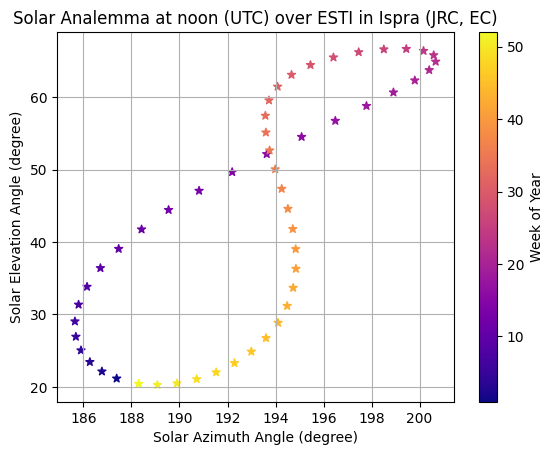

In [28]:
# Get specific dates in this case all 2018
timestamps = pd.date_range('2020-01-01 12:00:00', '2021-01-01 12:00:00', freq='W', tz=timezone)

position = model_solar_position_overview_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angles=False,
)

data = pd.DataFrame({'Datetime': timestamps, 
                   'Solar Declination': position[0].degrees,
                   'Solar Hour Angle': position[1].degrees,
                   'Solar Zenith': position[2].degrees,
                   'Solar Altitude': position[3].degrees,
                   'Solar Azimuth': position[4].degrees,
                   'Solar Incidence':position[7].degrees,
                    })

# Plotting the Analemma
plt.scatter(data['Solar Azimuth'], data['Solar Altitude'], marker="*", c=timestamps.isocalendar().week, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Week of Year')
plt.xlabel('Solar Azimuth Angle (degree)')
plt.ylabel('Solar Elevation Angle (degree)')
plt.title('Solar Analemma at noon (UTC) over ESTI in Ispra (JRC, EC)')
plt.grid()
plt.show()

## References

- [Solar Position](https://assessingsolar.org/notebooks/solar_position.html) article by The Assessing Solar Community (2022)